In [105]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [70]:
MNIST_1 = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

MNIST_2 = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [71]:
class Noisy(torch.utils.data.Dataset):
    
    def __init__(self, dataset, phase=None):

        if phase == 'train':
            start = 0
            end = int(len(dataset)*.75)
        elif phase == 'val':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)

        self.dataset = dataset.data[start:end] / 255

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = self.dataset[idx] + torch.rand(28, 28) / 2
        target = self.dataset[idx]
            
        return data, target

In [72]:
train_dataset = Noisy(MNIST_1, 'train')
val_dataset = Noisy(MNIST_1, 'val')
test_dataset = Noisy(MNIST_2, 'test')

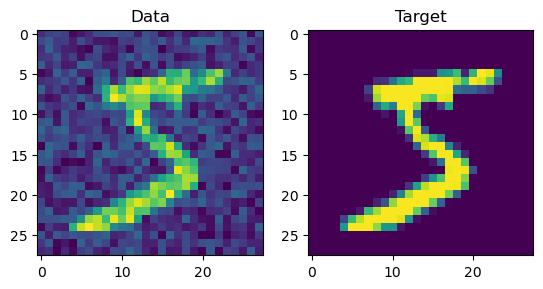

In [73]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(train_dataset[0][0].squeeze())
axs[1].imshow(train_dataset[0][1].squeeze())

axs[0].title.set_text('Data')
axs[1].title.set_text('Target')

plt.show()

In [74]:
# Hyperparameters

batch_size = 64
learning_rate = 0.01
num_epochs = 30

In [95]:
denoiser = nn.Sequential(
    # encode
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),

    # decode
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 1, kernel_size=3, padding=1),
    nn.ReLU(),
)

In [96]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [98]:
optimizer = optim.SGD(denoiser.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_fn = torch.nn.CrossEntropyLoss()

In [102]:
%%capture # suppress ouput

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

denoiser.to(device)

In [106]:
total_progress = tqdm(total=num_epochs, desc='Total progress')
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_progress = tqdm(total=len(train_loader), desc=f'Training epoch #{epoch}...', leave=False)
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_progress.update()
    epoch_progress.close()
    
    model.eval()
    val_progress = tqdm(total=len(val_loader), desc=f'Validating epoch #{epoch}...', leave=False)
    val_losses = []
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        val_losses.append(loss.item())
        val_progress.update()
    val_progress.close()
    
    mean_val_loss = np.mean(val_losses)
    epoch_losses.append(mean_val_loss)
    if mean_val_loss == min(epoch_losses):
        torch.save(model, 'least_loss.pt')
        
    scheduler.step(mean_val_loss)
    
    print(f"Val loss #{epoch}: {np.mean(val_losses)}")
    print(f"Val accuracy #{epoch}: {current_accuracy}")
    
    total_progress.update()

total_progress.close()

Total progress:   0%|          | 0/30 [00:00<?, ?it/s]

NameError: name 'model' is not defined